In [5]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os
import itertools

In [6]:
# get previous results
cwd = os.getcwd()
previosu_results_dir = os.path.join(cwd, "results", "previous_results.yml")
with open(previosu_results_dir, 'r') as file:
    previous_results = yaml.safe_load(file)
print(previous_results)

{'drills': {'adder': {'area': 892.53, 'delay': 1897.05}, 'bar': {'area': 1400.85, 'delay': 775.18}, 'log2': {'area': 17879.51, 'delay': 7438.65}, 'max': {'area': 1008.0, 'delay': 3764.34}, 'multiplier': {'area': 17135.58, 'delay': 3998.84}, 'sine': {'area': 3030.07, 'delay': 3796.02}, 'sqrt': {'area': 8978.95, 'delay': 168539.27}, 'square': {'area': 12598.29, 'delay': 2180.41}}, 'majoritydrills_aig': {'adder': {'area': 728.07, 'delay': 1658.1}, 'bar': {'area': 1199.06, 'delay': 795.22}, 'log2': {'area': 18023.45, 'delay': 7452.34}, 'max': {'area': 1048.59, 'delay': 3598.47}, 'multiplier': {'area': 15881.24, 'delay': 3877.19}, 'sine': {'area': 3129.22, 'delay': 3791.24}, 'sqrt': {'area': 8856.01, 'delay': 169679.61}, 'square': {'area': 12041.21, 'delay': 2352.39}}, 'majoritydrills_mig': {'adder': {'area': 1056.99, 'delay': 1808.33}, 'bar': {'area': 1583.27, 'delay': 795.27}, 'log2': {'area': 16671.36, 'delay': 7977.06}, 'max': {'area': 1215.39, 'delay': 3777.65}, 'multiplier': {'area': 

In [7]:
result_dir = os.path.join(os.getcwd(), "results")
experiment_results_dirs = os.listdir(result_dir)
results = []
for dir in experiment_results_dirs:
    data_dir = os.path.join(result_dir, dir, "results.npz")
    if os.path.exists(data_dir):
        results.append(data_dir)
        print(data_dir)

/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/more_actions_gcn_lstm_square_Abc_Env_PPO_2023-01-24-00-05/results.npz
/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/lstm_paper_replication_square_Abc_Env_PPO_2023-01-27-14-15/results.npz
/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/graph_lstm_basic_actions_multiplier_Abc_Env_PPO_2023-01-09-15-35/results.npz
/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/more_actions_random_square_Abc_Env_Num_Rand_Traj_5000_2023-01-21-00-25/results.npz
/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/basic_actions_random_bar_Abc_Env_Num_Rand_Traj_5000_2023-01-10-18-02/results.npz
/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/more_actions_gcn_lstm_bar_Abc_Env_PPO_2023-01-23-13-02/results.npz
/home/kunzro/workspace/Reinforcement_Learning_for_Logic_Optimization/results/lstm_paper_r

In [5]:
experiment_results = {}
for dir in results:
    data = np.load(dir)
    print(data["areas"].reshape((-1, 50)))

[[893.22912598 893.22912598 893.22912598 ... 883.66467285 883.66467285
  883.66467285]
 [883.66467285 883.66467285 883.66467285 ... 836.30877686 836.30877686
  836.30877686]
 [836.30877686 836.30877686 836.30877686 ... 852.8717041  852.8717041
  853.10498047]
 ...
 [892.29602051 892.29602051 892.29602051 ... 892.29602051 892.29602051
  892.29602051]
 [892.29602051 892.29602051 892.29602051 ... 892.29602051 892.29602051
  892.29602051]
 [892.29602051 892.29602051 892.29602051 ... 892.29602051 892.29602051
  892.29602051]]


ValueError: cannot reshape array of size 84035 into shape (50)

In [4]:
# The name of the experiment
experiment_env = "Abc_Env"
experiment_circuit = "adder"
experiment_algo = "PPO"
experiment_date = "2023-01-03-20-03"
experiment_tag = "lstm_replication"
experiment_string = f"{experiment_env}_{experiment_circuit}_{experiment_algo}_{experiment_date}"
if experiment_tag is not None:
    experiment_string += f"_{experiment_tag}"
result_dir = os.path.join(os.getcwd(), "results", experiment_string)
experiment_config_dir = os.path.join(result_dir, "experiment_config.yml")
if not os.path.exists(experiment_config_dir):
    print("experiment config not found")
else:
    with open(experiment_config_dir) as f:
        experiment_config = yaml.safe_load(f)
    print(experiment_config)

np_data_dir = os.path.join(result_dir, "results.npz")
if not os.path.exists(np_data_dir):
    print("result not found")
else:
    data = np.load(np_data_dir)
my_results = {}
for k in data.keys():
    print(f"{k} shape: {data[k].shape}")
    my_results[k] = data[k]


{'MAX_STEPS': 40, 'circuit_file': 'circuits/adder.v', 'circuit_name': 'adder', 'delay_reward_factor': 10, 'env': 'Abc_Env', 'library_file': 'libraries/asap7.lib', 'mockturtle': {'graph_type': 'mig'}, 'optimizations': {'aig': ['rewrite', 'rewrite -z', 'refactor', 'refactor -z', 'resub', 'resub -z', 'balance', 'dc2', 'ifraig', 'dch -f; dc2', 'dch -f; if -g', 'if -g'], 'mig': ['rewrite', 'rewrite -azg', 'rewrite -udc', 'rewrite -pd', 'rewrite -azg -udc', 'rewrite -azg -pd', 'rewrite -udc -pd', 'rewrite -azg -udc -pd', 'balance', 'balance -c', 'resub', 'resub -pd']}, 'preprocessor_pref': None, 'special_tag': 'lstm_replication', 'target_delay': 2000, 'train_iterations': 50, 'use_graph': True, 'use_previous_action': True}
rewards shape: (20, 1, 50, 40)
areas shape: (20, 1, 50, 40)
delays shape: (20, 1, 50, 40)
actions shape: (20, 1, 50, 40)


In [5]:
# find the relevant points
areas = my_results["areas"].reshape((-1, experiment_config["MAX_STEPS"]))
delays = my_results["delays"].reshape((-1, experiment_config["horizon"]))
actions = my_results["actions"].reshape((-1, experiment_config["horizon"]))
target_delay = experiment_config["target_delay"]
min_valid_area = areas[delays<=target_delay].min()
delay_at_min_valid_area = delays[areas==min_valid_area].max()
print(min_valid_area, delay_at_min_valid_area)

663.4483032226562 1630.807861328125


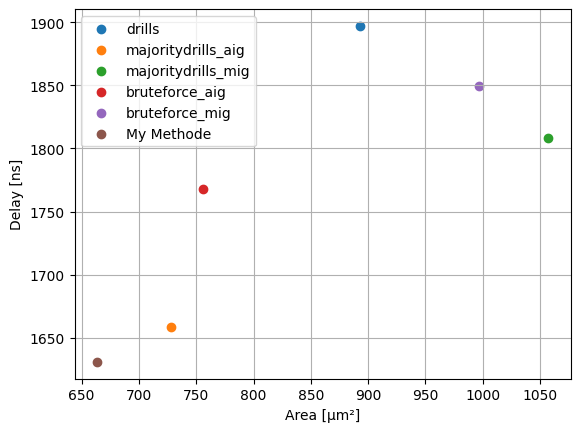

In [6]:
fig, ax = plt.subplots()

circuit = experiment_config["circuit_name"]
for methode, res in previous_results.items():
    ax.scatter(res[circuit]["area"], res[circuit]["delay"], label=methode)

ax.scatter(min_valid_area, delay_at_min_valid_area, label="My Methode")

ax.legend()
ax.grid(True)
ax.set_ylabel("Delay [ns]")
ax.set_xlabel("Area [μm²]")

plt.show()

In [5]:
# find some interesting facts about the solution space
print(f"Num of rollouts: {areas.shape[0]}")
print(f"Num of unique areas: {np.unique(areas).shape[0]}")
print(f"Num of unique delays: {np.unique(delays).shape[0]}")
unique_area_delay_combinations = set()
for area, delay in zip(areas.flatten(), delays.flatten()):
    unique_area_delay_combinations.add((area, delay))
print(f"Num of unique area-delay combinations: {len(unique_area_delay_combinations)}")

min_valid_area_indices = np.argwhere(areas==min_valid_area)
print(f"Num of optimal solutions: {min_valid_area_indices.shape[0]}")

unique_optimal_tradjectories = set()
for row, column in min_valid_area_indices:
    unique_optimal_tradjectories.add(tuple(actions[row, :column+1].tolist()))

optimal_tradjectories = []
for row, column in min_valid_area_indices:
    optimal_tradjectories.append(actions[row, :column+1].tolist())

print(f"num of unique optimal trajectories: {len(unique_optimal_tradjectories)}")
print(f"num of optimal trajectories: {len(optimal_tradjectories)}")

for tradjectory in optimal_tradjectories:
    print(tradjectory)

NameError: name 'areas' is not defined

Automated plots from different trials for all circuits

In [62]:
result_dir = os.path.join(os.getcwd(), "results")
experiment_results_dirs = os.listdir(result_dir)
results_dirs = []
for dir in experiment_results_dirs:
    data_dir = os.path.join(result_dir, dir)
    if os.path.exists(os.path.join(data_dir, "results.npz")) and os.path.exists(os.path.join(data_dir, "experiment_config.yml")):
        results_dirs.append(data_dir)

def get_result_fitting_description(results, desc: list, excludes: list, circuit_name):
    fitting_results = []
    for result in results:
        if all([el in result for el in desc]) and circuit_name in result and not any([el in result for el in excludes]):
            fitting_results.append(result)
    assert len(fitting_results) < 2, f"more than one fitting results found: {fitting_results}"
    if len(fitting_results) == 0:
        print(f"no fitting result found for circuit: {circuit_name} and desc: {desc}")
    if len(fitting_results) == 1:
        return fitting_results[0]
    else:
        return None

def load_results_and_experiment_config(result_dir):
    experiment_config_dir = os.path.join(result_dir, "experiment_config.yml")
    np_data_dir = os.path.join(result_dir, "results.npz")
    assert os.path.exists(experiment_config_dir), "experiment config not found"
    assert os.path.exists(np_data_dir), "result not found"
    with open(experiment_config_dir) as f:
        experiment_config = yaml.safe_load(f)
    data = np.load(np_data_dir)
    my_results = {}
    for k in data.keys():
        # print(f"{k} shape: {data[k].shape}")
        my_results[k] = data[k]
    return my_results, experiment_config


def get_best_solution(result_data, experiment_config):
    # find the relevant points
    if "seq_len" in experiment_config:
        areas = result_data["areas"].reshape((-1, experiment_config["seq_len"]))
        delays = result_data["delays"].reshape((-1, experiment_config["seq_len"]))
        actions = result_data["actions"].reshape((-1, experiment_config["seq_len"]))
        rewards = result_data["rewards"].reshape((-1, experiment_config["seq_len"]))
    else:
        areas = result_data["areas"].reshape((-1, experiment_config["horizon"]))
        delays = result_data["delays"].reshape((-1, experiment_config["horizon"]))
        actions = result_data["actions"].reshape((-1, experiment_config["horizon"]))
        rewards = result_data["rewards"].reshape((-1, experiment_config["horizon"]))
    target_delay = experiment_config["target_delay"]
    valid_areas = areas[delays<=target_delay]
    if valid_areas.size > 0:
        min_valid_area = valid_areas.min()
        delay_at_min_valid_area = delays[areas==min_valid_area].min()
        return min_valid_area, delay_at_min_valid_area, experiment_config["experiment_name"]
    else:
        max_reward_idx = np.argmax(rewards)
        print(f"No solution fullfilling the delay constraing found in {experiment_config['experiment_name']}")
        print(f"max reward: {rewards.flatten()[max_reward_idx]}")
        max_reward_area = areas.flatten()[max_reward_idx]
        max_reward_delay = delays.flatten()[max_reward_idx]
        return max_reward_area, max_reward_delay, experiment_config["experiment_name"]
        


def plot_results_for_circuit(previous_results, results_dirs, descriptions, excludes, circuit_name):
    fitting_results = []
    for desc, excl in zip(descriptions, excludes):
        fitting_desc = get_result_fitting_description(results_dirs, desc, excl, circuit_name)
        if fitting_desc is not None:
            fitting_results.append(fitting_desc)

    results_data = []
    for result_dir in fitting_results:
        results_data.append(load_results_and_experiment_config(result_dir))

    best_results = []
    for result_data in results_data:
        best_results.append(get_best_solution(*result_data))

    fig, ax = plt.subplots()

    markers = itertools.cycle(["o", "+", "1", "2", "3", "*", "x"])

    for methode, res in previous_results.items():
        ax.scatter(res[circuit_name]["area"], res[circuit_name]["delay"], label=methode, marker=next(markers))

    for best_result in best_results:
        ax.scatter(best_result[0], best_result[1], label=best_result[2], marker=next(markers))

    experiment_config = results_data[0][1]
    print(experiment_config["target_delay"])
    ax.autoscale(True)
    ax.axhline(y=experiment_config["target_delay"], linewidth=1, color='red', linestyle='--')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)
    ax.set_ylabel("Delay [ns]")
    ax.set_xlabel("Area [μm²]")

    plt.show()

No solution fullfilling the delay constraing found in lstm_paper_replication
max reward: 8.158818958287856
7500


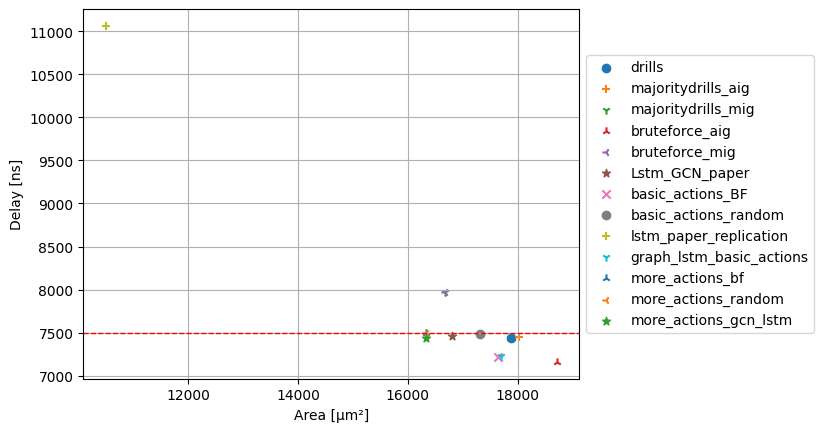

In [63]:
plot_results_for_circuit(previous_results, results_dirs, descriptions=[["basic_actions_BF"], ["basic_actions_random"], ["lstm_paper_replication"], ["graph_lstm_basic_actions"], ["more_actions_bf"], ["more_actions_random"], ["more_actions_gcn_lstm"]], excludes=[[], [], [], [], [], [], ["29"]], circuit_name="log2")